In [1]:
import numpy as np
import networkx as nx
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time
import matplotlib.pyplot as plt

## Dirichlet Graph Auto-Encoders

In [2]:
%cd ~/structure-encoding/dgvae
%run train_generate

/Users/kieran/structure-encoding/dgvae


RDKit ERROR: [14:09:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:09:36] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit WARNING: [14:09:36] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [14:09:36] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:09:36] WARNING: not removing hydrogen atom without neighbors
[14:09:36] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [14:09:36] WARNING: not removing hydrogen atom without neighbors
[14:09:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:09:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:09:36] WARNING: not removing hydrogen atom without neighbors
[14:09:36] WARNING: not removing hydrogen atom without neighbors
[14:09:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:09:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:09:

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
targets is deprecated, use labels instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-05-27 14:09:44.584585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 14:09:44.601042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch: 0001 train_loss= 2.31720 train_acc= 0.52652 val_roc= 0.92907 val_ap= 0.68183 reconstruction error= 0.51444 log_like= 0.81973 RMSE= 0.66919 time= 3.03208
Epoch: 0002 train_loss= 2.29805 train_acc= 0.52674 val_roc= 0.94442 val_ap= 0.73369 reconstruction error= 0.50790 log_like= 0.80778 RMSE= 0.67121 time= 3.96279
Epoch: 0003 train_loss= 2.28530 train_acc= 0.51596 val_roc= 0.96046 val_ap= 0.79180 reconstruction error= 0.49675 log_like= 0.81182 RMSE= 0.59981 time= 3.27073
Epoch: 0004 train_loss= 2.28305 train_acc= 0.52284 val_roc= 0.95328 val_ap= 0.75159 reconstruction error= 0.50270 log_like= 0.80446 RMSE= 0.62448 time= 3.51228
Epoch: 0005 train_loss= 2.25669 train_acc= 0.52720 val_roc= 0.96335 val_ap= 0.81131 reconstruction error= 0.48445 log_like= 0.80892 RMSE= 0.58937 time= 3.16834
Epoch: 0006 train_loss= 2.27721 train_acc= 0.53489 val_roc= 0.96163 val_ap= 0.79263 reconstruction error= 0.47113 log_like= 0.80132 RMSE= 0.54709 time= 2.87321
Epoch: 0007 train_loss= 2.27055 train_ac

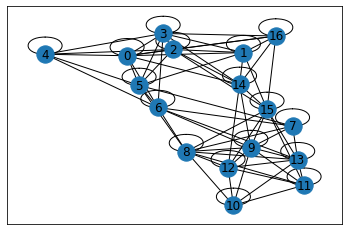

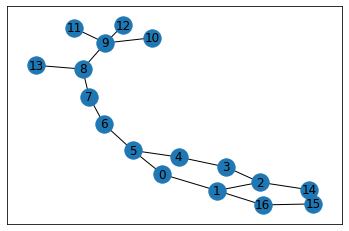

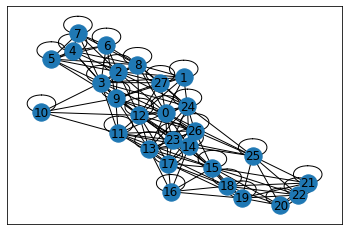

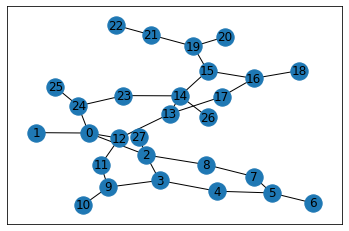

In [4]:
def sigmoid(x):
    return .5 * (1 + np.tanh(.5 * x))

for idx, adj in enumerate(graph_val[0:2]):
    feed_dict = construct_feed_dict(adj_norms_val[idx], adj_labels_val[idx], features, placeholders)
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.z_mean, feed_dict=feed_dict)
    adj_rec = np.dot(emb, emb.T)
    size = val_size[idx]
    preds_all = adj_rec[:size, :size]
    pred_matrix = np.round(sigmoid(preds_all))
    G = nx.from_numpy_matrix(pred_matrix)
    nx.draw_networkx(G)
    plt.show()
    G = nx.from_numpy_matrix(adj[:size, :size])
    nx.draw_networkx(G)
    plt.show()

## Equivariant Diffusion for Molecule Generation in 3D

In [2]:
try:
    from rdkit import Chem
except ModuleNotFoundError:
    pass

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'e3_diffusion_for_molecules')

import copy
import utils
import argparse
import wandb
from configs.datasets_config import get_dataset_info
from os.path import join
from qm9 import dataset
from qm9.models import get_optim, get_model
from equivariant_diffusion import en_diffusion
from equivariant_diffusion.utils import assert_correctly_masked
from equivariant_diffusion import utils as flow_utils
import torch
import time
import pickle
from qm9.utils import prepare_context, compute_mean_mad
from train_test import train_epoch, test, analyze_and_save

from configs.datasets_config import qm9_with_h, qm9_without_h
import qm9.visualizer as vis
from qm9.analyze import check_stability
from qm9.sampling import sample_chain, sample

import matplotlib.pyplot as plt
%matplotlib inline

from easydict import EasyDict as edict

## Training

In [30]:
# Params
dataset_name = 'qm9'
no_cuda = True
remove_h = True
cuda = not no_cuda and torch.cuda.is_available()
# device = torch.device("cuda" if cuda else "cpu")
device = 'cpu'
dtype = torch.float32
resume = None
batch_size = 32
num_workers = 2
conditioning = []
include_charges = True

dataset_info = get_dataset_info(dataset_name, remove_h)

atom_encoder = dataset_info['atom_encoder']
atom_decoder = dataset_info['atom_decoder']

utils.create_folders(edict({'exp_name':'test'}))

# Retrieve QM9 dataloaders
dataloaders, charge_scale = dataset.retrieve_dataloaders(edict({'dataset':dataset_name, 'num_workers': 2, 'batch_size':batch_size, 'filter_n_atoms': None, 'datadir': '/Users/kieran/structure-encoding/e3_diffusion_for_molecules/qm9/data/qm9','remove_h':remove_h, 'include_charges':True }))

data_dummy = next(iter(dataloaders['train']))


if len(conditioning) > 0:
    print(f'Conditioning on {conditioning}')
    property_norms = compute_mean_mad(dataloaders, conditioning, dataset)
    context_dummy = prepare_context(conditioning, data_dummy, property_norms)
    context_node_nf = context_dummy.size(2)
else:
    context_node_nf = 0
    property_norms = None

context_node_nf = context_node_nf

args = edict({'conditioning': [], 'include_charges': include_charges, 'condition_time':True,
                'context_node_nf': context_node_nf, 'nf': 128, 'n_layers': 4, 
                'attention': True, 'tanh': True, 'model': 'egnn_dynamics', 'norm_constant': 1,
                'inv_sublayers':1, 'sin_embedding':False, 'normalization_factor': 1, 'aggregation_method': 'sum',
                'probabilistic_model': 'diffusion', 'diffusion_steps': 500, 'diffusion_noise_schedule':'polynomial_2',
                'diffusion_noise_precision':1e-5, 'diffusion_loss_type':'l2', 'normalize_factors': [1,4,10], 
                'lr':1e-4, 'start_epoch':0, 'n_epochs':10, 'ema_decay':.9999, 'augment_noise':0,
                'data_augmentation':False, 'ode_regularization': 1e-3, 'clip_grad':True})
# Create EGNN flow
model, nodes_dist, prop_dist = get_model(args, device, dataset_info, dataloaders['train'])
if prop_dist is not None:
    prop_dist.set_normalizer(property_norms)
model = model.to(device)
optim = get_optim(args, model)
# print(model)

gradnorm_queue = utils.Queue()
gradnorm_queue.add(3000)  # Add large value that will be flushed.



## main


model_dp = model

# Initialize model copy for exponential moving average of params.
if args.ema_decay > 0:
    model_ema = copy.deepcopy(model)
    ema = flow_utils.EMA(args.ema_decay)
    model_ema_dp = model_ema
else:
    ema = None
    model_ema = model
    model_ema_dp = model_dp

best_nll_val = 1e8
best_nll_test = 1e8
for epoch in range(args.start_epoch, args.n_epochs):
    start_epoch = time.time()
    train_epoch(args=args, loader=dataloaders['train'], epoch=epoch, model=model, model_dp=model_dp,
                model_ema=model_ema, ema=ema, device=device, dtype=dtype, property_norms=property_norms,
                nodes_dist=nodes_dist, dataset_info=dataset_info,
                gradnorm_queue=gradnorm_queue, optim=optim, prop_dist=prop_dist)
    print(f"Epoch took {time.time() - start_epoch:.1f} seconds.")

    if epoch % args.test_epochs == 0:
        if isinstance(model, en_diffusion.EnVariationalDiffusion):
            wandb.log(model.log_info(), commit=True)

        if not args.break_train_epoch:
            analyze_and_save(args=args, epoch=epoch, model_sample=model_ema, nodes_dist=nodes_dist,
                                dataset_info=dataset_info, device=device,
                                prop_dist=prop_dist, n_samples=args.n_stability_samples)
        nll_val = test(args=args, loader=dataloaders['valid'], epoch=epoch, eval_model=model_ema_dp,
                        partition='Val', device=device, dtype=dtype, nodes_dist=nodes_dist,
                        property_norms=property_norms)
        nll_test = test(args=args, loader=dataloaders['test'], epoch=epoch, eval_model=model_ema_dp,
                        partition='Test', device=device, dtype=dtype,
                        nodes_dist=nodes_dist, property_norms=property_norms)

        if nll_val < best_nll_val:
            best_nll_val = nll_val
            best_nll_test = nll_test
            if args.save_model:
                args.current_epoch = epoch + 1
                utils.save_model(optim, 'outputs/%s/optim.npy' % args.exp_name)
                utils.save_model(model, 'outputs/%s/generative_model.npy' % args.exp_name)
                if args.ema_decay > 0:
                    utils.save_model(model_ema, 'outputs/%s/generative_model_ema.npy' % args.exp_name)
                with open('outputs/%s/args.pickle' % args.exp_name, 'wb') as f:
                    pickle.dump(args, f)

            if args.save_model:
                utils.save_model(optim, 'outputs/%s/optim_%d.npy' % (args.exp_name, epoch))
                utils.save_model(model, 'outputs/%s/generative_model_%d.npy' % (args.exp_name, epoch))
                if args.ema_decay > 0:
                    utils.save_model(model_ema, 'outputs/%s/generative_model_ema_%d.npy' % (args.exp_name, epoch))
                with open('outputs/%s/args_%d.pickle' % (args.exp_name, epoch), 'wb') as f:
                    pickle.dump(args, f)
        print('Val loss: %.4f \t Test loss:  %.4f' % (nll_val, nll_test))
        print('Best val loss: %.4f \t Best test loss:  %.4f' % (best_nll_val, best_nll_test))

Entropy of n_nodes: H[N] -0.5481089949607849
alphas2 [9.99990000e-01 9.99982000e-01 9.99958001e-01 9.99918003e-01
 9.99862007e-01 9.99790014e-01 9.99702026e-01 9.99598046e-01
 9.99478076e-01 9.99342118e-01 9.99190176e-01 9.99022254e-01
 9.98838355e-01 9.98638484e-01 9.98422646e-01 9.98190846e-01
 9.97943090e-01 9.97679383e-01 9.97399731e-01 9.97104143e-01
 9.96792624e-01 9.96465182e-01 9.96121825e-01 9.95762562e-01
 9.95387400e-01 9.94996350e-01 9.94589420e-01 9.94166620e-01
 9.93727960e-01 9.93273451e-01 9.92803104e-01 9.92316930e-01
 9.91814941e-01 9.91297149e-01 9.90763566e-01 9.90214206e-01
 9.89649081e-01 9.89068205e-01 9.88471593e-01 9.87859258e-01
 9.87231215e-01 9.86587480e-01 9.85928068e-01 9.85252996e-01
 9.84562278e-01 9.83855933e-01 9.83133976e-01 9.82396427e-01
 9.81643302e-01 9.80874619e-01 9.80090398e-01 9.79290657e-01
 9.78475416e-01 9.77644695e-01 9.76798513e-01 9.75936891e-01
 9.75059851e-01 9.74167412e-01 9.73259599e-01 9.72336431e-01
 9.71397932e-01 9.70444124e-01 9

AttributeError: 'EasyDict' object has no attribute 'n_report_steps'

## Sampling

In [1]:
model_path = '/Users/kieran/structure-encoding/e3_diffusion_for_molecules/outputs/edm_qm9'
with open(join(model_path, 'args.pickle'), 'rb') as f:
    args = pickle.load(f)

# CAREFUL with this -->
if not hasattr(args, 'normalization_factor'):
    args.normalization_factor = 1
if not hasattr(args, 'aggregation_method'):
    args.aggregation_method = 'sum'

args.cuda = not args.no_cuda and torch.cuda.is_available()
device = "cpu"
dtype = torch.float32
utils.create_folders(args)

dataset_info = get_dataset_info(args.dataset, args.remove_h)

dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

flow, nodes_dist, prop_dist = get_model(
    args, device, dataset_info, dataloaders['train'])
flow.to(device)

fn = 'generative_model_ema.npy' if args.ema_decay > 0 else 'generative_model.npy'
flow_state_dict = torch.load(join(eval_args.model_path, fn),
                                map_location=device)

flow.load_state_dict(flow_state_dict)

print('Sampling handful of molecules.')
sample_different_sizes_and_save(
    args, eval_args, device, flow, nodes_dist,
    dataset_info=dataset_info, n_samples=30, prop_dist=prop_dist)

print('Sampling stable molecules.')
sample_only_stable_different_sizes_and_save(
    args, eval_args, device, flow, nodes_dist,
    dataset_info=dataset_info, n_samples=10, n_tries=2*10)
print('Visualizing molecules.')
vis.visualize(
    join(eval_args.model_path, 'eval/molecules/'), dataset_info,
    max_num=100, spheres_3d=True)

print('Sampling visualization chain.')
save_and_sample_chain(
    args, eval_args, device, flow,
    n_tries=eval_args.n_tries, n_nodes=eval_args.n_nodes,
    dataset_info=dataset_info)

Namespace(actnorm=True, aggregation_method='sum', attention=True, augment_noise=0, batch_size=64, break_train_epoch=False, brute_force=False, clip_grad=True, condition_time=True, conditioning=[], context_node_nf=0, cuda=False, current_epoch=1001, data_augmentation=False, datadir='qm9/temp', dataset='qm9', dequantization='argmax_variational', device=device(type='cpu'), diffusion_loss_type='l2', diffusion_noise_precision=1e-05, diffusion_noise_schedule='polynomial_2', diffusion_steps=1000, dp=True, ema_decay=0.9999, exp_name='polynomial_2_final_0', filter_n_atoms=None, generate_epochs=1, include_charges=True, inv_sublayers=1, lr=0.0001, model='egnn_dynamics', n_epochs=3000, n_layers=9, n_report_steps=1, n_stability_samples=1000, nf=256, no_cuda=False, no_wandb=False, norm_constant=1, normalization_factor=1, normalize_factors=[1, 4, 10], num_workers=0, ode_regularization=0.001, online=True, probabilistic_model='diffusion', remove_h=False, resume=None, save_model=True, sin_embedding=False,

NameError: name 'eval_args' is not defined

In [3]:
import numpy as np
data = np.load('e3_diffusion_for_molecules/outputs/edm_qm9/generative_model.npy')
# for u in data:
#     print(u)
# print(data['archive/data/0'])
# for f in data.files[:5]:
#     print(data[f])
exp_path = 'e3_diffusion_for_molecules/outputs/edm_qm9'
with open(join(exp_path, 'args.pickle'), 'rb') as f:
    args = pickle.load(f)

dataset_info = get_dataset_info(args.dataset, args.remove_h)

atom_encoder = dataset_info['atom_encoder']
atom_decoder = dataset_info['atom_decoder']

args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")
dtype = torch.float32

utils.create_folders(args)

# Retrieve QM9 dataloaders
dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

data_dummy = next(iter(dataloaders['train']))


if len(args.conditioning) > 0:
    print(f'Conditioning on {args.conditioning}')
    property_norms = compute_mean_mad(dataloaders, args.conditioning, args.dataset)
    context_dummy = prepare_context(args.conditioning, data_dummy, property_norms)
    context_node_nf = context_dummy.size(2)
else:
    context_node_nf = 0
    property_norms = None

args.context_node_nf = context_node_nf


# Create EGNN flow
model, nodes_dist, prop_dist = get_model(args, device, dataset_info, dataloaders['train'])
if prop_dist is not None:
    prop_dist.set_normalizer(property_norms)
model = model.to(device)
optim = get_optim(args, model)
# print(model)

gradnorm_queue = utils.Queue()
gradnorm_queue.add(3000)  # Add large value that will be flushed.



flow_state_dict = torch.load(join(exp_path, 'flow_ema.npy'), map_location=torch.device('cpu'))
optim_state_dict = torch.load(join(exp_path, 'optim_0.npy'), map_location=torch.device('cpu'))
model.load_state_dict(flow_state_dict)
optim.load_state_dict(optim_state_dict)


Entropy of n_nodes: H[N] -2.475700616836548
alphas2 [9.99990000e-01 9.99988000e-01 9.99982000e-01 ... 2.59676966e-05
 1.39959211e-05 1.00039959e-05]
gamma [-11.51291546 -11.33059532 -10.92513058 ...  10.55863126  11.17673063
  11.51251595]


In [32]:
# # print(model)
# def analyze_and_save(epoch, model_sample, nodes_dist, args, device, dataset_info, prop_dist,
#                      n_samples=1000, batch_size=100):
#     print(f'Analyzing molecule stability at epoch {epoch}...')
#     batch_size = min(batch_size, n_samples)
#     assert n_samples % batch_size == 0
#     molecules = {'one_hot': [], 'x': [], 'node_mask': []}
#     for i in range(int(n_samples/batch_size)):
#         nodesxsample = nodes_dist.sample(batch_size)
#         one_hot, charges, x, node_mask = sample(args, device, model_sample, dataset_info, prop_dist,
#                                                 nodesxsample=nodesxsample)

#         molecules['one_hot'].append(one_hot.detach().cpu())
#         molecules['x'].append(x.detach().cpu())
#         molecules['node_mask'].append(node_mask.detach().cpu())

#     molecules = {key: torch.cat(molecules[key], dim=0) for key in molecules}
#     validity_dict, rdkit_tuple = analyze_stability_for_molecules(molecules, dataset_info)

#     wandb.log(validity_dict)
#     if rdkit_tuple is not None:
#         wandb.log({'Validity': rdkit_tuple[0][0], 'Uniqueness': rdkit_tuple[0][1], 'Novelty': rdkit_tuple[0][2]})
#     return validity_dict
from qm9.sampling import sample
molecules = {'one_hot': [], 'x': [], 'node_mask': []}
batch_size = 1
for i in range(1):
    nodesxsample = nodes_dist.sample(batch_size)
    one_hot, charges, x, node_mask = sample(args, device, model, dataset_info, prop_dist,
                                            nodesxsample=nodesxsample)

    molecules['one_hot'].append(one_hot.detach().cpu())
    molecules['x'].append(x.detach().cpu())
    molecules['node_mask'].append(node_mask.detach().cpu())

molecules = {key: torch.cat(molecules[key], dim=0) for key in molecules}
# validity_dict, rdkit_tuple = analyze_stability_for_molecules(molecules, dataset_info)

In [39]:
molecules.keys()

dict_keys(['one_hot', 'x', 'node_mask'])

# Molecule Vis

## Sample

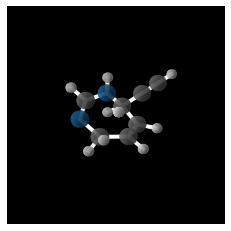

In [40]:
positions = molecules['x'].view(-1, 3)
positions_centered = positions - positions.mean(dim=0, keepdim=True)
one_hot = molecules['one_hot'].view(-1, 5).type(torch.float32)
atom_type = torch.argmax(one_hot, dim=1).numpy()

plot_data3d(
    positions_centered, atom_type, dataset_info=dataset_info,
    spheres_3d=True)

## From Dataset

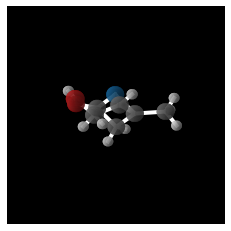

In [7]:
class Args:
    batch_size = 1
    num_workers = 0
    filter_n_atoms = None
    datadir = 'qm9/temp'
    dataset = 'qm9'
    remove_h = False
    include_charges = True

cfg = Args()

dataloaders, charge_scale = dataset.retrieve_dataloaders(cfg)
sample = next(iter(dataloaders['train']))
positions = sample['positions'].view(-1, 3)
positions_centered = positions - positions.mean(dim=0, keepdim=True)
one_hot = sample['one_hot'].view(-1, 5).type(torch.float32)
atom_type = torch.argmax(one_hot, dim=1).numpy()

plot_data3d(
    positions_centered, atom_type, dataset_info=dataset_info,
    spheres_3d=True)


In [22]:
import pandas as pd
smiles_first = pd.read_pickle('/Users/kieran/structure-encoding/e3_diffusion_for_molecules/qm9/temp/qm9_smiles.pickle')
smiles_second = pd.read_pickle('/Users/kieran/structure-encoding/e3_diffusion_for_molecules/qm9/temp/qm9_second_half_smiles.pickle')
smiles_second[sample['index']-len(smiles_first)]

tensor([110227])


'[H]N([H])c1nc(C(=O)C([H])([H])[H])no1'

In [6]:
import torch
import numpy as np
import os
import glob
import random
import matplotlib
import imageio


matplotlib.use('Agg')
import matplotlib.pyplot as plt
from qm9 import bond_analyze
##############
### Files ####
###########-->


def save_xyz_file(path, one_hot, charges, positions, dataset_info, id_from=0, name='molecule', node_mask=None):
    try:
        os.makedirs(path)
    except OSError:
        pass

    if node_mask is not None:
        atomsxmol = torch.sum(node_mask, dim=1)
    else:
        atomsxmol = [one_hot.size(1)] * one_hot.size(0)

    for batch_i in range(one_hot.size(0)):
        f = open(path + name + '_' + "%03d.txt" % (batch_i + id_from), "w")
        f.write("%d\n\n" % atomsxmol[batch_i])
        atoms = torch.argmax(one_hot[batch_i], dim=1)
        n_atoms = int(atomsxmol[batch_i])
        for atom_i in range(n_atoms):
            atom = atoms[atom_i]
            atom = dataset_info['atom_decoder'][atom]
            f.write("%s %.9f %.9f %.9f\n" % (atom, positions[batch_i, atom_i, 0], positions[batch_i, atom_i, 1], positions[batch_i, atom_i, 2]))
        f.close()


def load_molecule_xyz(file, dataset_info):
    with open(file, encoding='utf8') as f:
        n_atoms = int(f.readline())
        one_hot = torch.zeros(n_atoms, len(dataset_info['atom_decoder']))
        charges = torch.zeros(n_atoms, 1)
        positions = torch.zeros(n_atoms, 3)
        f.readline()
        atoms = f.readlines()
        for i in range(n_atoms):
            atom = atoms[i].split(' ')
            atom_type = atom[0]
            one_hot[i, dataset_info['atom_encoder'][atom_type]] = 1
            position = torch.Tensor([float(e) for e in atom[1:]])
            positions[i, :] = position
        return positions, one_hot, charges


def load_xyz_files(path, shuffle=True):
    files = glob.glob(path + "/*.txt")
    if shuffle:
        random.shuffle(files)
    return files

#<----########
### Files ####
##############
def draw_sphere(ax, x, y, z, size, color, alpha):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v)) * 0.8  # Correct for matplotlib.
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    # for i in range(2):
    #    ax.plot_surface(x+random.randint(-5,5), y+random.randint(-5,5), z+random.randint(-5,5),  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)

    ax.plot_surface(x + xs, y + ys, z + zs, rstride=2, cstride=2, color=color, linewidth=0,
                    alpha=alpha)
    # # calculate vectors for "vertical" circle
    # a = np.array([-np.sin(elev / 180 * np.pi), 0, np.cos(elev / 180 * np.pi)])
    # b = np.array([0, 1, 0])
    # b = b * np.cos(rot) + np.cross(a, b) * np.sin(rot) + a * np.dot(a, b) * (
    #             1 - np.cos(rot))
    # ax.plot(np.sin(u), np.cos(u), 0, color='k', linestyle='dashed')
    # horiz_front = np.linspace(0, np.pi, 100)
    # ax.plot(np.sin(horiz_front), np.cos(horiz_front), 0, color='k')
    # vert_front = np.linspace(np.pi / 2, 3 * np.pi / 2, 100)
    # ax.plot(a[0] * np.sin(u) + b[0] * np.cos(u), b[1] * np.cos(u),
    #         a[2] * np.sin(u) + b[2] * np.cos(u), color='k', linestyle='dashed')
    # ax.plot(a[0] * np.sin(vert_front) + b[0] * np.cos(vert_front),
    #         b[1] * np.cos(vert_front),
    #         a[2] * np.sin(vert_front) + b[2] * np.cos(vert_front), color='k')
    #
    # ax.view_init(elev=elev, azim=0)


def plot_molecule(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color,
                  dataset_info):
    # draw_sphere(ax, 0, 0, 0, 1)
    # draw_sphere(ax, 1, 1, 1, 1)

    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    # ax.set_facecolor((1.0, 0.47, 0.42))
    colors_dic = np.array(dataset_info['colors_dic'])
    radius_dic = np.array(dataset_info['radius_dic'])
    area_dic = 1500 * radius_dic ** 2
    # areas_dic = sizes_dic * sizes_dic * 3.1416

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if spheres_3d:
        for i, j, k, s, c in zip(x, y, z, radii, colors):
            draw_sphere(ax, i.item(), j.item(), k.item(), 0.7 * s, c, alpha)
    else:
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha,
                   c=colors)  # , linewidths=2, edgecolors='#FFFFFF')

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = dataset_info['atom_decoder'][atom_type[i]], \
                           dataset_info['atom_decoder'][atom_type[j]]
            s = sorted((atom_type[i], atom_type[j]))
            pair = (dataset_info['atom_decoder'][s[0]],
                    dataset_info['atom_decoder'][s[1]])
            if 'qm9' in dataset_info['name']:
                draw_edge_int = bond_analyze.get_bond_order(atom1, atom2, dist)
                line_width = (3 - 2) * 2 * 2
            elif dataset_info['name'] == 'geom':
                draw_edge_int = bond_analyze.geom_predictor(pair, dist)
                # Draw edge outputs 1 / -1 value, convert to True / False.
                line_width = 2
            else:
                raise Exception('Wrong dataset_info name')
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    # linewidth_factor = draw_edge_int  # Prop to number of
                    # edges.
                    linewidth_factor = 1
                ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                        linewidth=line_width * linewidth_factor,
                        c=hex_bg_color, alpha=alpha)


def plot_data3d(positions, atom_type, dataset_info, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1.):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#666666'

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    # ax.xaxis.pane.set_edgecolor('#D0D0D0')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    plot_molecule(ax, positions, atom_type, alpha, spheres_3d,
                  hex_bg_color, dataset_info)

    if 'qm9' in dataset_info['name']:
        max_value = positions.abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    elif dataset_info['name'] == 'geom':
        max_value = positions.abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    else:
        raise ValueError(dataset_info['name'])

    dpi = 120 if spheres_3d else 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()


def plot_data3d_uncertainty(
        all_positions, all_atom_types, dataset_info, camera_elev=0, camera_azim=0,
        save_path=None, spheres_3d=False, bg='black', alpha=1.):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#666666'

    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    # ax.xaxis.pane.set_edgecolor('#D0D0D0')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    for i in range(len(all_positions)):
        positions = all_positions[i]
        atom_type = all_atom_types[i]
        plot_molecule(ax, positions, atom_type, alpha, spheres_3d,
                      hex_bg_color, dataset_info)

    if 'qm9' in dataset_info['name']:
        max_value = all_positions[0].abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    elif dataset_info['name'] == 'geom':
        max_value = all_positions[0].abs().max().item()

        # axis_lim = 3.2
        axis_lim = min(40, max(max_value / 2 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)
    else:
        raise ValueError(dataset_info['name'])

    dpi = 120 if spheres_3d else 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()


def plot_grid():
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid

    im1 = np.arange(100).reshape((10, 10))
    im2 = im1.T
    im3 = np.flipud(im1)
    im4 = np.fliplr(im2)

    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(6, 6),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, [im1, im2, im3, im4]):
        # Iterating over the grid returns the Axes.

        ax.imshow(im)

    plt.show()


def visualize(path, dataset_info, max_num=25, wandb=None, spheres_3d=False):
    files = load_xyz_files(path)[0:max_num]
    for file in files:
        positions, one_hot, charges = load_molecule_xyz(file, dataset_info)
        atom_type = torch.argmax(one_hot, dim=1).numpy()
        dists = torch.cdist(positions.unsqueeze(0), positions.unsqueeze(0)).squeeze(0)
        dists = dists[dists > 0]
        print("Average distance between atoms", dists.mean().item())
        plot_data3d(positions, atom_type, dataset_info=dataset_info, save_path=file[:-4] + '.png',
                    spheres_3d=spheres_3d)

        if wandb is not None:
            path = file[:-4] + '.png'
            # Log image(s)
            im = plt.imread(path)
            wandb.log({'molecule': [wandb.Image(im, caption=path)]})


def visualize_chain(path, dataset_info, wandb=None, spheres_3d=False,
                    mode="chain"):
    files = load_xyz_files(path)
    files = sorted(files)
    save_paths = []

    for i in range(len(files)):
        file = files[i]

        positions, one_hot, charges = load_molecule_xyz(file, dataset_info=dataset_info)

        atom_type = torch.argmax(one_hot, dim=1).numpy()
        fn = file[:-4] + '.png'
        plot_data3d(positions, atom_type, dataset_info=dataset_info,
                    save_path=fn, spheres_3d=spheres_3d, alpha=1.0)
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    print(f'Creating gif with {len(imgs)} images')
    # Add the last frame 10 times so that the final result remains temporally.
    # imgs.extend([imgs[-1]] * 10)
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})


def visualize_chain_uncertainty(
        path, dataset_info, wandb=None, spheres_3d=False, mode="chain"):
    files = load_xyz_files(path)
    files = sorted(files)
    save_paths = []

    for i in range(len(files)):
        if i + 2 == len(files):
            break

        file = files[i]
        file2 = files[i+1]
        file3 = files[i+2]

        positions, one_hot, _ = load_molecule_xyz(file, dataset_info=dataset_info)
        positions2, one_hot2, _ = load_molecule_xyz(
            file2, dataset_info=dataset_info)
        positions3, one_hot3, _ = load_molecule_xyz(
            file3, dataset_info=dataset_info)

        all_positions = torch.stack([positions, positions2, positions3], dim=0)
        one_hot = torch.stack([one_hot, one_hot2, one_hot3], dim=0)

        all_atom_type = torch.argmax(one_hot, dim=2).numpy()
        fn = file[:-4] + '.png'
        plot_data3d_uncertainty(
            all_positions, all_atom_type, dataset_info=dataset_info,
            save_path=fn, spheres_3d=spheres_3d, alpha=0.5)
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    print(f'Creating gif with {len(imgs)} images')
    # Add the last frame 10 times so that the final result remains temporally.
    # imgs.extend([imgs[-1]] * 10)
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})
